# First Experiments
* 3 base models
* Std_Norm
* No data augmentatition
* MSE

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ResNet-Autoencoder" data-toc-modified-id="ResNet-Autoencoder-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ResNet Autoencoder</a></span><ul class="toc-item"><li><span><a href="#Architecture-definition" data-toc-modified-id="Architecture-definition-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Architecture definition</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Cuantitative" data-toc-modified-id="Cuantitative-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Cuantitative</a></span><ul class="toc-item"><li><span><a href="#Validation-set" data-toc-modified-id="Validation-set-1.3.1.1"><span class="toc-item-num">1.3.1.1&nbsp;&nbsp;</span>Validation set</a></span></li><li><span><a href="#Test-set" data-toc-modified-id="Test-set-1.3.1.2"><span class="toc-item-num">1.3.1.2&nbsp;&nbsp;</span>Test set</a></span></li></ul></li><li><span><a href="#Cualitative-(How-it-reconstruct)" data-toc-modified-id="Cualitative-(How-it-reconstruct)-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Cualitative (How it reconstruct)</a></span><ul class="toc-item"><li><span><a href="#Validation-set" data-toc-modified-id="Validation-set-1.3.2.1"><span class="toc-item-num">1.3.2.1&nbsp;&nbsp;</span>Validation set</a></span></li><li><span><a href="#Test-set" data-toc-modified-id="Test-set-1.3.2.2"><span class="toc-item-num">1.3.2.2&nbsp;&nbsp;</span>Test set</a></span></li></ul></li></ul></li></ul></li></ul></div>

https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

In [14]:
import os
import glob
import tensorflow as tf
import random
from my_tf_data_loader_optimized import tf_data_png_loader
import matplotlib.pyplot as plt

GLOBAL_BATCH_SIZE = 16
train_percentage = 0.85
INPUT_SHAPE = (128,128)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## ResNet Autoencoder

### Architecture definition

### Training

Training is made in scripts:

* **`./residual_cae.py`** (architecture)
* **`./residual_cae_experiment.py`** (experiment configuration and running)
* **`./results/res_cae_e100_b64_is128/`** (folder with results: hisotry.csv, model.h5 and aarch_picture.png)

### Evaluation
#### Cuantitative

##### Validation set

##### Test set

In [15]:
TEST_img_PATH = '..'+os.path.sep+'IXI-T1'+os.path.sep+'PNG'+os.path.sep+'test_folder'+os.path.sep+'test'
test_img_files = glob.glob(TEST_img_PATH+os.path.sep+'*.png')
params = {'batch_size': GLOBAL_BATCH_SIZE,
          'cache':False,
          'shuffle_buffer_size':1000,
          'resize':INPUT_SHAPE
         }
test_ds = tf_data_png_loader(test_img_files,
                             **params,
                             train=False
                            ).get_tf_ds_generator()


#### Cualitative (How it reconstruct)
##### Validation set
##### Test set

In [16]:
elem = next(iter(test_ds))
elem[0].shape, elem[1].shape

(TensorShape([16, 128, 128, 1]), TensorShape([16, 128, 128, 1]))

In [17]:
res_cae_e100_b64_is128 = tf.keras.models.load_model('results/res_cae_0_MinMax__e100_b32_is128/res_cae_0_MinMax__model.h5')

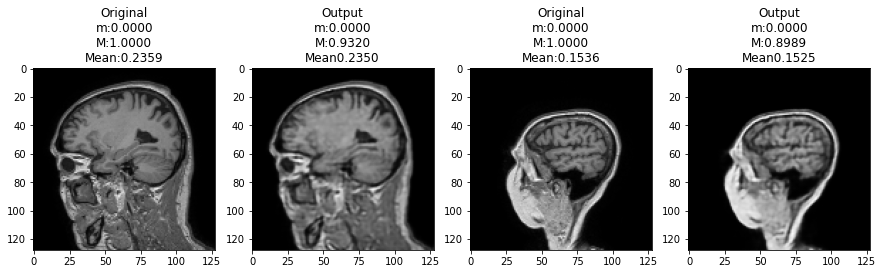

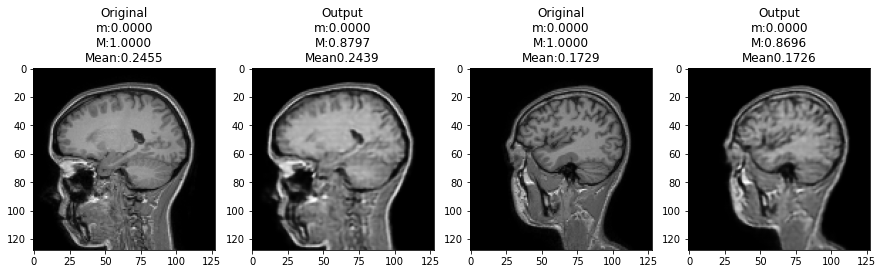

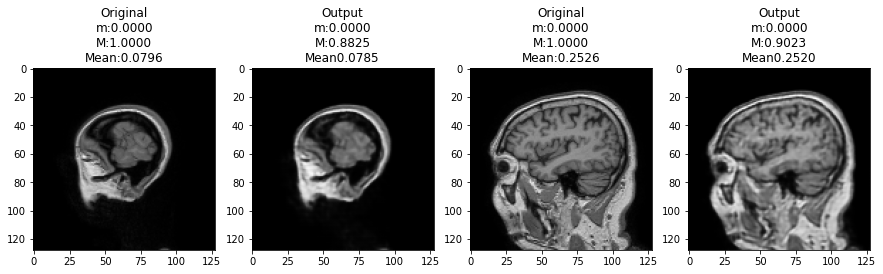

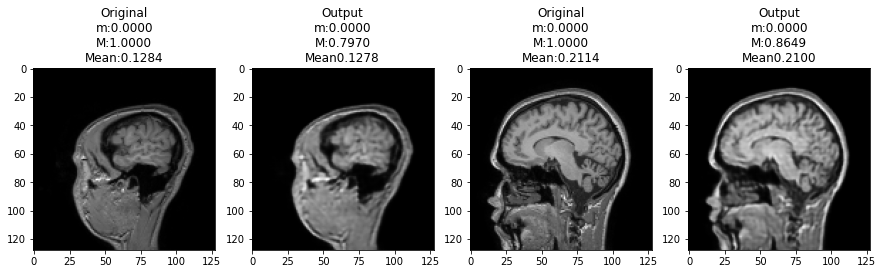

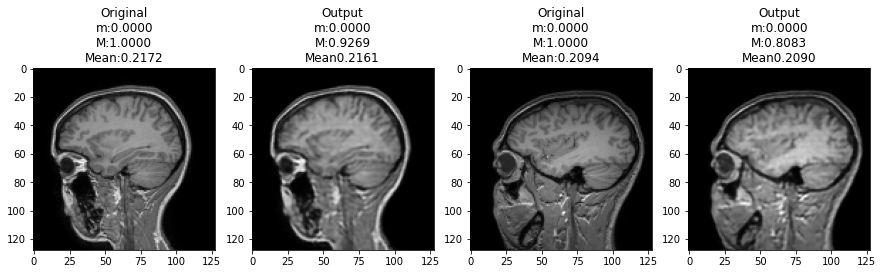

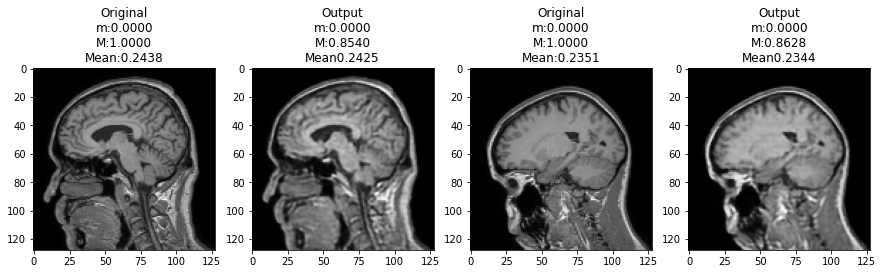

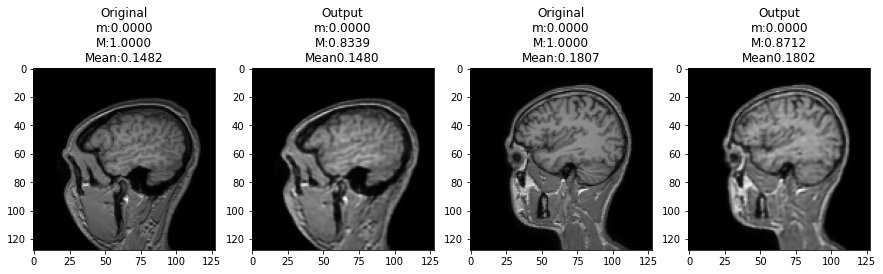

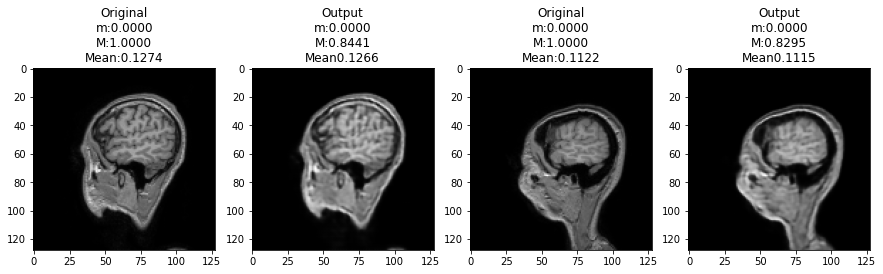

In [18]:

for i in range(elem[0].shape[0]):
    if i%2==0:
        plt.figure(figsize=(15,5))
        idx=1
    else:
        idx=3
    plt.subplot(1,4,idx)
    tit = 'Original\nm:{:.4f}\nM:{:.4f}\nMean:{:.4f}'.format(tf.math.reduce_min(elem[1][i]).numpy(),
                                                  tf.math.reduce_max(elem[1][i]).numpy(),
                                                  tf.math.reduce_mean(elem[1][i]).numpy())
    plt.title(tit)
    plt.imshow(elem[1][i], cmap='gray')
    
    plt.subplot(1,4,idx+1)
    decode = res_cae_e100_b64_is128.predict(tf.expand_dims(elem[0][i], axis=0))[0]
    tit = 'Output\nm:{:.4f}\nM:{:.4f}\nMean{:.4f}'.format(tf.math.reduce_min(decode).numpy(),
                                                  tf.math.reduce_max(decode).numpy(),
                                                  tf.math.reduce_mean(decode).numpy())
    plt.title(tit)
    plt.imshow(decode, cmap='gray')
    
    if not i%2==0:
        plt.show()

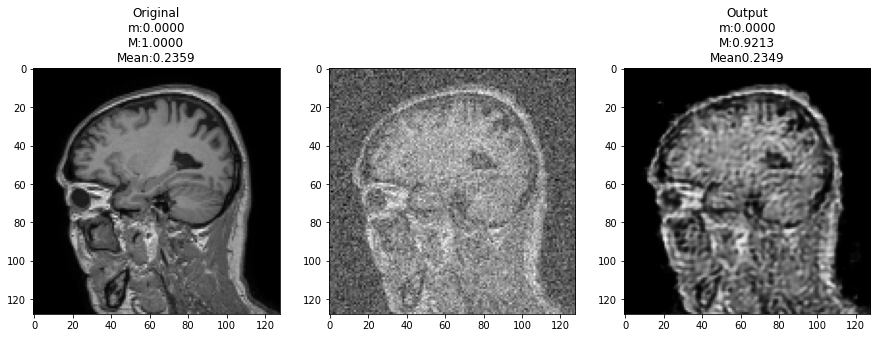

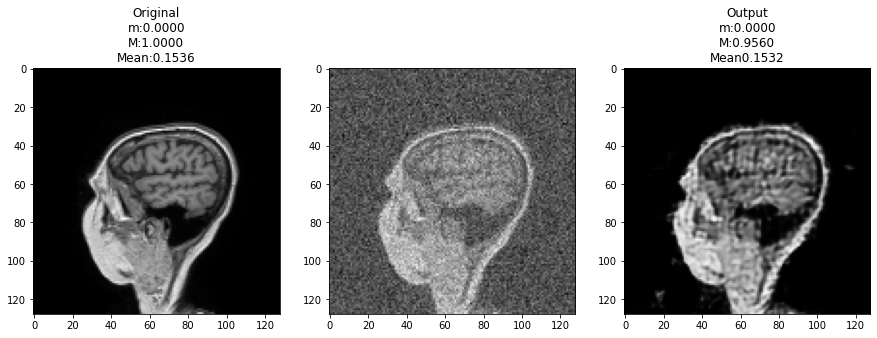

In [31]:
for i in range(2):#elem[0].shape[0]):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    tit = 'Original\nm:{:.4f}\nM:{:.4f}\nMean:{:.4f}'.format(tf.math.reduce_min(elem[1][i]).numpy(),
                                                  tf.math.reduce_max(elem[1][i]).numpy(),
                                                  tf.math.reduce_mean(elem[1][i]).numpy())
    plt.title(tit)
    plt.imshow(elem[1][i], cmap='gray')
       
    plt.subplot(1,3,2)
    noise = tf.random.normal(shape=tf.shape(elem[1][i]), mean=0, stddev=0.15, dtype=tf.float32)
    noise_img = tf.add(elem[1][i], noise)
    plt.imshow(noise_img, cmap='gray')      
    
    plt.subplot(1,3,3)
    decode = res_cae_e100_b64_is128.predict(tf.expand_dims(noise_img, axis=0))[0]
    tit = 'Output\nm:{:.4f}\nM:{:.4f}\nMean{:.4f}'.format(tf.math.reduce_min(decode).numpy(),
                                                  tf.math.reduce_max(decode).numpy(),
                                                  tf.math.reduce_mean(decode).numpy())
    plt.title(tit)
    plt.imshow(decode, cmap='gray')
    
    if not i%2==0:
        plt.show()

In [32]:
1e-4

0.0001